In [1]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.viewer.mpl import showDataContainerAsMatrix
from pygimli.viewer import pv

In [2]:
# We load the data file from the example repository. It represents a crosshole
# data set published by Kuras et al. (2009) in the frame of the ALERT project.

In [3]:
# data = ert.load("crosshole3d.dat")
data = pg.getExampleData("ert/crosshole3d.dat")
print(data)

23/03/23 - 12:08:52 - pyGIMLi - INFO - Looking for ert/crosshole3d.dat in gimli-org/example-data/


Data: Sensors: 36 data: 753, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


In [4]:
# There are 36 electrodes, each 9 in four boreholes, and 1256 data that are
# resistances only. Therefore we first compute the geometric factors and then
# the apparent resistivities, of which we plot the last few values.
#

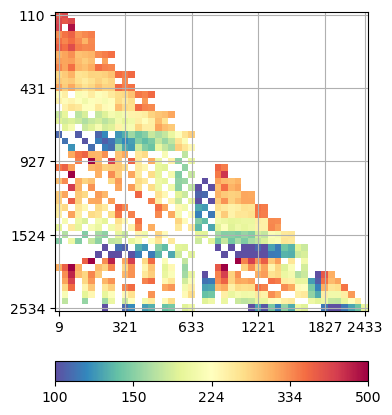

In [5]:
data["k"] = ert.geometricFactors(data, dim=3)
data["rhoa"] = data["r"] * data["k"]
ab = data["a"] * 100 + data["b"]
mn = data["m"] * 100 + data["n"]
showDataContainerAsMatrix(data, ab, mn, "rhoa", cMap="Spectral_r", cMin=100, cMax=500);

In [6]:
# %%%
# We first extract the borehole locations, i.e. the x and y positions of the
# electrodes. From these we create a rectangle with 40% boundary and marker 2
# and add the borehole positions to it.
#

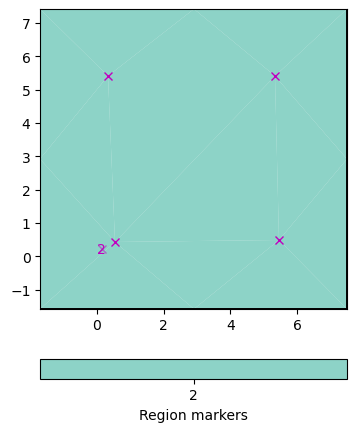

In [7]:
elPosXY = np.unique(np.column_stack([pg.x(data), pg.y(data)]), axis=0)
rect = mt.createRectangle(pnts=elPosXY, minBBOffset=1.4, marker=2)
for elpos in elPosXY:
    rect.createNode(*elpos, 0)

ax, cb = pg.show(rect)
ax.plot(*elPosXY.T, "mx")

In [8]:
# %%%
# From this PLC, we create a mesh using a maximum cell size.
# We add an outer (modelling) boundary.
#

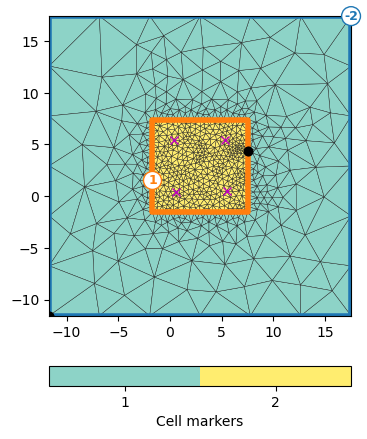

In [9]:
bnd = 5
rectMesh = mt.createMesh(rect, quality=34.5, area=.2)
mesh2d = mt.appendTriangleBoundary(
    rectMesh, boundary=bnd, isSubSurface=False, marker=1)
ax, cb = pg.show(mesh2d, markers=True, showMesh=True)
ax.plot(*elPosXY.T, "mx")

In [10]:
# %%%
# We create a vertical discretization vector with dense spacing in the range of
# the electrodes and a coarser discretization above and below.
#

In [11]:
dTop, dBot = 3.5, 10.7
dzIn, dzOut = 0.3, 0.7
zTop = -np.arange(0, dTop, dzOut)  # the upper layer
zMid = -np.arange(dTop, dBot, dzIn)  # the middle
zBot = -np.arange(dBot, dBot+bnd+.1, dzOut)  # the lower layer
zVec = np.concatenate([zTop, zMid, zBot])
print(zVec)
mesh = mt.createMesh3D(mesh2d, zVec, pg.core.MARKER_BOUND_HOMOGEN_NEUMANN,
                       pg.core.MARKER_BOUND_MIXED)

print(mesh)
for c in mesh.cells():
    cd = -c.center().z()  # center depth
    if cd < dTop or cd > dBot:
        c.setMarker(1)

[ -0.   -0.7  -1.4  -2.1  -2.8  -3.5  -3.8  -4.1  -4.4  -4.7  -5.   -5.3
  -5.6  -5.9  -6.2  -6.5  -6.8  -7.1  -7.4  -7.7  -8.   -8.3  -8.6  -8.9
  -9.2  -9.5  -9.8 -10.1 -10.4 -10.7 -11.4 -12.1 -12.8 -13.5 -14.2 -14.9
 -15.6]
Mesh: Nodes: 24864 Cells: 47448 Boundaries: 5840


In [19]:
# mesh["bla"] = pg.Vector(mesh.cellMarkers())
# print(mesh)
# len(mesh["bla"])

Mesh: Nodes: 24864 Cells: 47448 Boundaries: 5840
Mesh contains data: bla[0,...,2)


47448

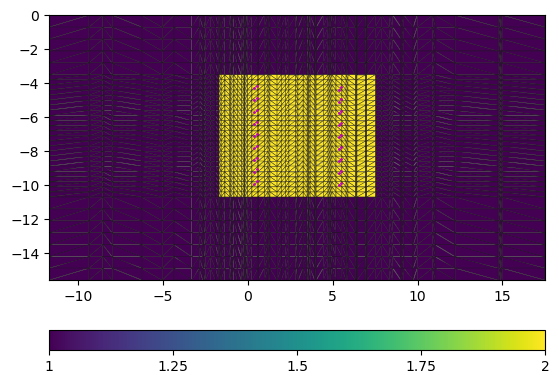

In [45]:
mesh["region"] = pg.Vector(mesh.cellMarkers())
sli = mt.extract2dSlice(mesh, dip=0)
ax, cb = pg.show(sli, "region", showMesh=True)
ax.plot(pg.x(data), pg.z(data), "mo", markersize=1)

In [32]:
pl, _ = pg.show(mesh, label="bla", style="wireframe", hold=1, clim=[0, 2])
# pv.drawMesh(pl, mesh, label="bla", style="surface",
#            filter={"threshold": dict(value=[1, 3], scalars="bla")})
pl.show()

Exception ignored in: <function BasePlotter.__del__ at 0x00000142AA49A670>
Traceback (most recent call last):
  File "C:\Program Files\software\Anaconda\lib\site-packages\pyvista\plotting\plotting.py", line 5358, in __del__
    if self._initialized:
AttributeError: 'Plotter' object has no attribute '_initialized'


TypeError: __init__() got an unexpected keyword argument 'clim'

We estimate an error using default values, i.e. 3% relative error and an
absolute error of 100uV at an assumed current of 100mA which is almost zero.
Inversion is run with less weight into the vertical direction.

In [ ]:
data["err"] = ert.estimateError(data)
mgr = ert.Manager(data)
mgr.invert(mesh=mesh, zWeight=0.2, verbose=True)
# mgr.showResult(cMin=100, cMax=500)

In [ ]:
showDataContainerAsMatrix(data, ab, mn, mgr.inv.response, cMap="Spectral_r", cMin=100, cMax=500)

In [ ]:
pd = mgr.paraDomain
pd["res"] = mgr.model
pl, _ = pg.show(pd, label="res", style="surface", cMap="Spectral_r", hold=1,
                filter={"clip": dict(normal=[1, 1, 0], origin=[2, 2, -6])})
# pl.add_points(np.column_stack([pg.x(data), pg.y(data), pg.z(data)]), color="magenta")
pl.add_points(data.sensors().array(), color="magenta")
pl.camera_position = "yz"
pl.camera.azimuth = 20
pl.camera.elevation = 20
pl.camera.zoom(1.2)
pl.show()

In [ ]:
print(mesh)
print(pd)

References
----------
Coscia, I., S. Greenhalgh, N. Linde, A. Green, T. Günter, J. Doetsch, and T.
Vogt, 2010, A multi-borehole 3-D ERT monitoring system for aquifer
characterization using river flood events as a natural tracer: Ext. Abstr.
16th Annual EAGE meeting of Environmental and Engineering Geophysics.
Doetsch, J., Linde, N., Coscia, I., Greenhalgh, S., & Green, A. (2010):
Zonation for 3D aquifer characterization based on joint inversions of
multimethod crosshole geophysical data. GEOPHYSICS (2010),75(6): G53.